-------------
# Ponderada Semana 7:RNN com biblioteca
-------------

In [ ]:
!pip install kagglehub[pandas-datasets]

In [36]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "ProductPriceIndex.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "everydaycodings/produce-prices-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


<ipython-input-36-0429d8d51af3>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [2]:
df.head()

,productname,date,farmprice,atlantaretail,chicagoretail,losangelesretail,newyorkretail,averagespread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


In [3]:
df['productname'].unique()

array(['Strawberries', 'Romaine Lettuce', 'Red Leaf Lettuce', 'Potatoes',
       'Oranges', 'Iceberg Lettuce', 'Green Leaf Lettuce', 'Celery',
       'Cauliflower', 'Carrots', 'Cantaloupe', 'Broccoli Crowns',
       'Avocados', 'Broccoli Bunches', 'Asparagus', 'Flame Grapes',
       'Thompson Grapes', 'Honeydews', 'Tomatoes', 'Plums', 'Peaches',
       'Nectarines'], dtype=object)

In [4]:
df.value_counts('productname')

,count
productname,
Broccoli Crowns,1017
Cauliflower,1016
Green Leaf Lettuce,1015
Iceberg Lettuce,1014
Red Leaf Lettuce,1014
Carrots,1013
Romaine Lettuce,1013
Celery,1012
Strawberries,973


## Descreva as colunas do dataset

In [5]:
df.columns

Index(['productname', 'date', 'farmprice', 'atlantaretail', 'chicagoretail',
       'losangelesretail', 'newyorkretail', 'averagespread'],
      dtype='object')



*   productName: nome do produto(fruta ou vegetal)
*   date: data em que a informação de preço foi obtida
*   farmprice: preço da fruta ou vegetal comprado na fazenda
*   atlantaretail:preço do produto no varejo em Atlanta
*   chicagoretail:preço do produto no varejo em Chicago
*   losangelesretail:preço do produto no varejo em Los Angeles
*   newyorkretail:preço do produto no varejo em New York
*   averagespread:Média da diferença entre o preço da fazenda e do varejo





## Será feito um modelo de predição para o preço de iceberg lettuce

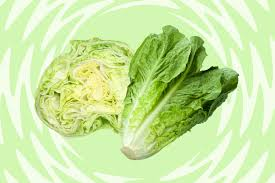

In [45]:
import pandas as pd

In [39]:
df['productname'] = 'Iceberg Lettuce'

In [40]:
#converter preços para float
for i in df.columns[2:]:
  df[i] = df[i].str.replace('$', '')
  df[i] = df[i].str.replace('%', '')
  df[i] = df[i].str.replace(',', '')
  df = df[df[i] != '']
  df[i].astype(float)


In [46]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

## Escolha uma métrica

A métrica escolhida foi MSE (Mean Squared Error) pois dado esse contexto de previsão de preço, a discrepância entre o valor predito e o valor real deve ser altamente penalizada, assim usando o MSE estaremos penalizando o erro ao elevar o valor ao quadrado, ressaltando principalmente grandes diferenças.

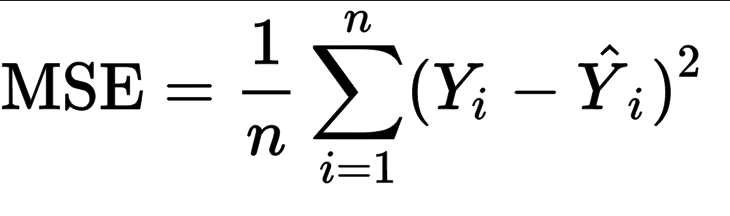

## Modelo de predição usando uma RNN

In [55]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Normalizar os preços
scaler = MinMaxScaler()
df['losangelesretail'] = scaler.fit_transform(df[['losangelesretail']])



In [52]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# criar sequencia temporal para dividir entre treino e teste

In [ ]:
seq_length = 20
prices = df['losangelesretail'].values
X, y = create_sequences(prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1) #transformando em um flatten para servir de entrada para a RNN


In [57]:
dates = df['date'].values[seq_length:]


X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.3, shuffle=False) #dividindo treino e teste 70/30


model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])


In [58]:
# Treinar modelo
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test))



Epoch 1/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 9/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 10/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 11/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 12/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 11

In [59]:
y_pred = model.predict(X_test) # fazer predições

# Reverter normalização para valores originais
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred) # Desfazer normalização para retornar os valores originais

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Análise do modelo

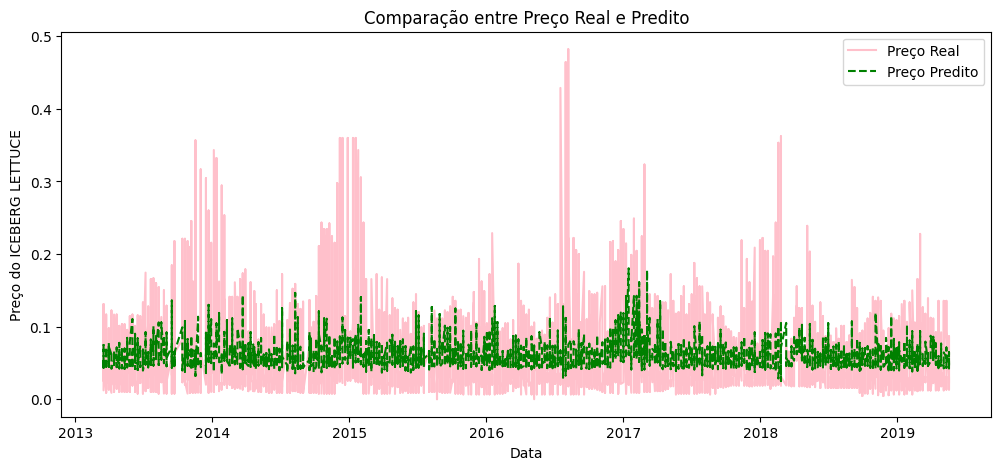

In [65]:

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label="Preço Real", color='pink')
plt.plot(dates_test, y_pred, label="Preço Predito", color='green', linestyle='dashed')
plt.xlabel("Data")
plt.ylabel("Preço do ICEBERG LETTUCE")
plt.legend()
plt.title("Comparação entre Preço Real e Predito")
plt.show()

Percebe-se que apesar do modelo ter sido capaz de captar as nuancias do preço e até ter uma loss baixa, contudo em períodos de grande variação do preço o modelo não foi capaz de acertar a predição, muito provavelmente pela função de perda aplicada, que penaliza fortemente grandes diferenças entre o real e o predito, fazendo com que o modelo seja menos incentivado a predizer um aumento ou diminuição brusca do preço